In [1]:
# 7.30 am 7 Jan 2020 until 11 am (4.5 hours)
# 11.30 am 7 Jan 2020 until 12pm (0.5 hour)
# 1pm 7 Jan 2020 until 2.30pm (1.5 hour)
# 11.45 am 8 Jan 2020 until 1.15 pm (1.5 hour)
# 3.30 pm 8 Jan 2020 until 6.30pm (3 hours)
# 9pm 8 Jan 2020 until 10.30 (1.5 hour)
# 9.30 am 9 Jan 2020 until 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
loan = pd.read_csv('./data/loan.csv')
payment = pd.read_csv('./data/payment.csv')
clarity_underwriting = pd.read_csv('./data/clarity_underwriting_variables.csv', low_memory=False)

# Data Cleaning, Exploration and Visualisation

## loan.csv

In [4]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])

We are only interested in funded loans to train a new predictive model, as only the funded loans tell us the history of the applicants. First, we have to confirm that there is no fpStatus when the loan is approved but not funded.

In [5]:
check_fpStatus = loan.loc[(loan['approved']==True) & (loan['isFunded']!=1)]['fpStatus'].unique()
check_fpStatus

array([nan], dtype=object)

In [6]:
funded_loan = loan.loc[(loan['approved']==True) & (loan['isFunded']==1)]
columns = list(funded_loan.columns)
columns = ['state'] + ['anon_ssn'] + [columns[0]] + columns[2:13] + columns[14:]
funded_loan = funded_loan[columns].sort_values(['state', 'anon_ssn', 'loanId'])
# print(funded_loan['anon_ssn'].value_counts())
funded_loan = funded_loan.set_index(['state', 'anon_ssn', 'loanId'])
mapping = dict(clarity_underwriting[['underwritingid', 'clearfraudscore']].values)
funded_loan['clearfraudscore'] = funded_loan.clarityFraudId.map(mapping)
funded_loan.drop(columns=['approved', 'isFunded', 'originated', 'clarityFraudId'], inplace=True)
all_states = funded_loan.index.get_level_values('state').unique()
all_applicants = funded_loan.index.get_level_values('anon_ssn').unique()

In [7]:
missing_data(funded_loan)

,Total,Percentage
clearfraudscore,6894,17.685085
nPaidOff,21,0.053871
fpStatus,9,0.023088
hasCF,0,0.000000
leadCost,0,0.000000
leadType,0,0.000000
originallyScheduledPaymentAmount,0,0.000000
loanAmount,0,0.000000
loanStatus,0,0.000000
originatedDate,0,0.000000


In [8]:
# missing charged off
funded_loan.loc[funded_loan['hasCF']==0]['loanStatus'].unique()

array(['Internal Collection', 'New Loan', 'Paid Off Loan',
       'External Collection', 'Pending Paid Off', 'Returned Item',
       'Settled Bankruptcy', 'Settlement Paid Off',
       'Charged Off Paid Off', 'Settlement Pending Paid Off'],
      dtype=object)

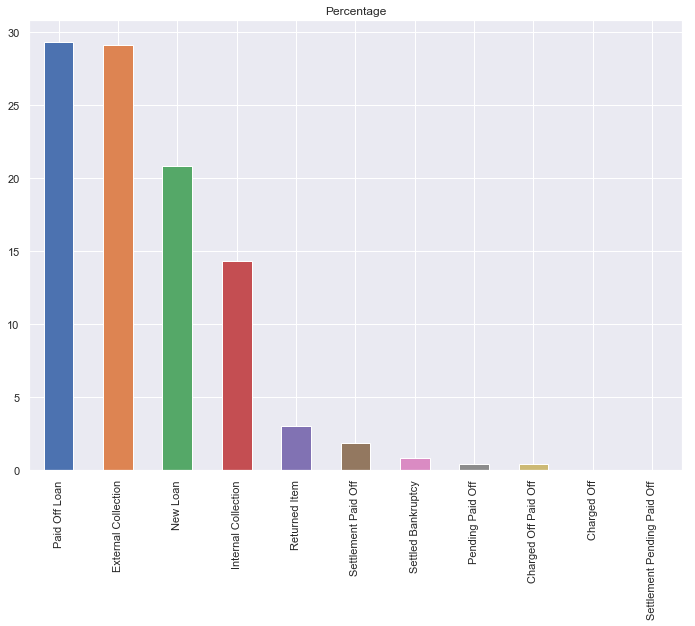

In [9]:
loanStatus_type_frequency = funded_loan['loanStatus'].value_counts(normalize=False).sort_values(ascending=False)
loanStatus_type_frequency = pd.concat([loanStatus_type_frequency, 100*loanStatus_type_frequency/loanStatus_type_frequency.sum()], axis=1)
loanStatus_type_frequency.columns = range(loanStatus_type_frequency.shape[1])
loanStatus_type_frequency.rename(columns={loanStatus_type_frequency.columns[0]: 'Count', loanStatus_type_frequency.columns[1]: 'Percentage'}, inplace=True)
loanStatus_type_frequency['Percentage'].plot.bar(rot=90)
plt.title('Percentage')
plt.show()

External Collection: outsource the debt-collection activity to a third party to recover funds that are past due, or from accounts that are in default

Internal Collection: internal department or a debt-collection subsidiary to handle the debt-collection activity***

Settled Bankruptcy: nothing is collected

Charged Off: occurs when a consumer becomes severely delinquent on a debt. Traditionally, creditors will make this declaration at the point of six months without payment

Settlement Pending Paid Off

Returned Item: only 1 payment missing due to insufficient funds

Settlement Paid Off: an agreement to pay less than the balance due to satisfy the debt has been fulfilled

Charged Off Paid Off: paid off the charge-off

Pending Paid Off

Settlement Pending Paid Off

New Loan: In the process, has been paid up to date




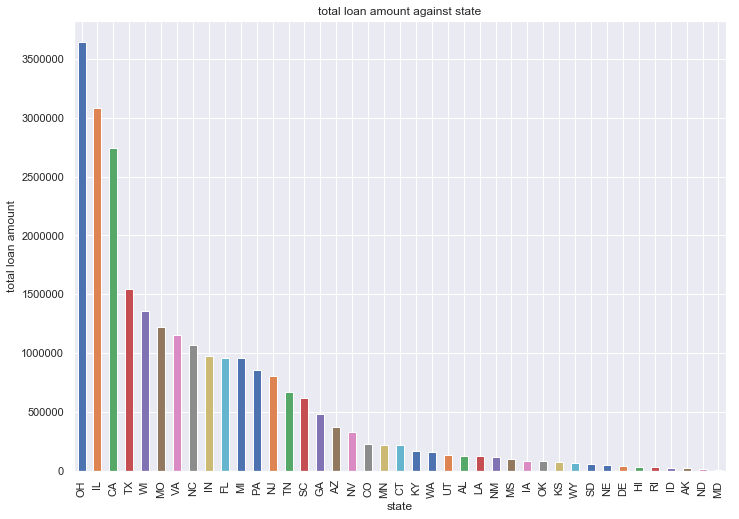

In [10]:
state_loan_ranking = funded_loan.groupby(funded_loan.index.get_level_values('state'))['loanAmount'].sum().sort_values(ascending=False)
state_loan_status_distribution = funded_loan.groupby(funded_loan.index.get_level_values('state'))['loanStatus'].value_counts(normalize=True)
state_loan_ranking.plot.bar(rot=90)
plt.title('total loan amount against state')
plt.xlabel('state')
plt.ylabel('total loan amount')
plt.show()

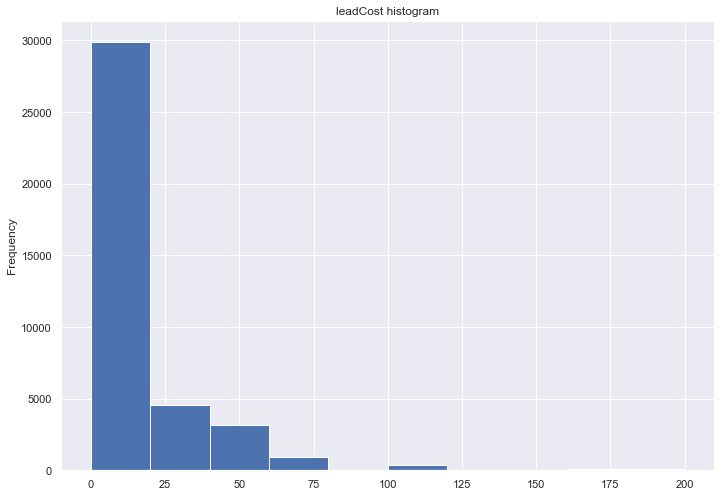

In [11]:
funded_loan['leadCost'].plot.hist()
plt.title('leadCost histogram')
plt.show()

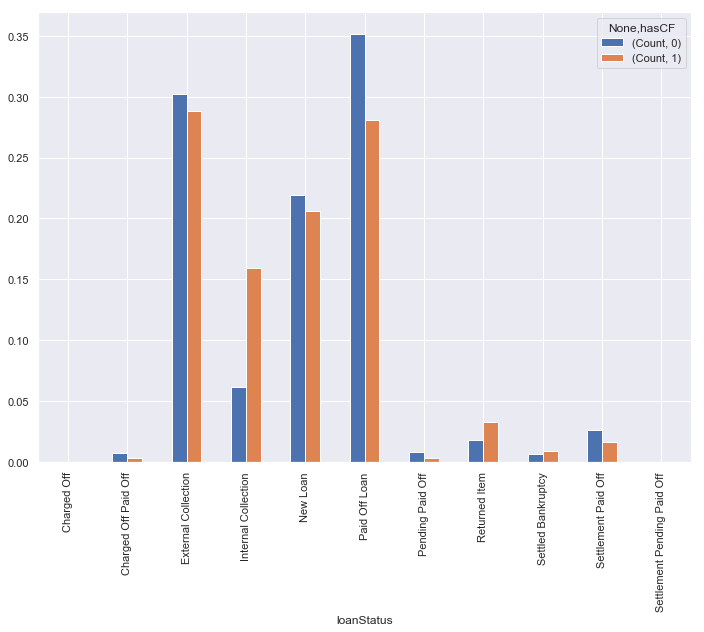

In [12]:
has_CF = pd.Series.to_frame(funded_loan.groupby('hasCF')['loanStatus'].value_counts(normalize=True))
has_CF.rename(columns={'loanStatus': 'Count'}, inplace=True)
has_CF.unstack(level=0).plot.bar()
plt.show()

In [13]:
funded_loan.loc[funded_loan['clearfraudscore'].isnull()==True]['leadType'].unique()

array(['rc_returning', 'bvMandatory', 'lead', 'organic', 'prescreen',
       'express', 'lionpay', 'repeat', 'instant-offer'], dtype=object)

## payment.csv

In [14]:
missing_data(payment)

,Total,Percentage
paymentReturnCode,657831,95.425784
paymentStatus,0,0.000000
paymentAmount,0,0.000000
fees,0,0.000000
principal,0,0.000000
paymentDate,0,0.000000
isCollection,0,0.000000
installmentIndex,0,0.000000
loanId,0,0.000000


A paymentStatus is marked 'Complete' for loanId=='LL-I-12152161'. Assume that means 'Checked'.

In [15]:
paid_amount = pd.Series.to_frame(payment.groupby(['loanId', 'paymentStatus'])['paymentAmount'].sum())
paid_amount.drop(labels=['Rejected', 'Cancelled', 'None', 'Skipped', 'Pending', 'Returned',
                         'Rejected Awaiting Retry'], axis=0, level='paymentStatus', inplace=True)
# paid_amount.loc[paid_amount.index.get_level_values('paymentStatus') == 'Complete']

In [16]:
mapping2 = dict(np.stack([paid_amount.index.get_level_values('loanId').values, paid_amount['paymentAmount'].values]).T)
funded_loan['paymentAmount'] = funded_loan.index.get_level_values('loanId').map(mapping2)
funded_loan['payloanRatio'] = funded_loan['paymentAmount']/funded_loan['loanAmount']

In [17]:
missing_data(funded_loan)

,Total,Percentage
payloanRatio,7140,18.316146
paymentAmount,7140,18.316146
clearfraudscore,6894,17.685085
nPaidOff,21,0.053871
fpStatus,9,0.023088
hasCF,0,0.000000
leadCost,0,0.000000
leadType,0,0.000000
originallyScheduledPaymentAmount,0,0.000000
loanAmount,0,0.000000


If loanStatus == New Loan, that means the loan has not expired yet. Hence, it should be removed from the credit score valuation.

In [18]:
funded_loan = funded_loan.drop(funded_loan.loc[funded_loan['loanStatus']=='New Loan'].index)

In [19]:
ratioPartition = pd.Series.to_frame(pd.cut(funded_loan['payloanRatio'], [0, 1, float('inf')]))
ratioPartition.rename({'payloanRatio': 'ratioPartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, ratioPartition], axis=1)

In [20]:
partition = pd.Series.to_frame(pd.cut(funded_loan['clearfraudscore'], [0, 200, 400, 600, 800, 1000]))
partition.rename({'clearfraudscore': 'clearfraudscorePartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, partition], axis=1)

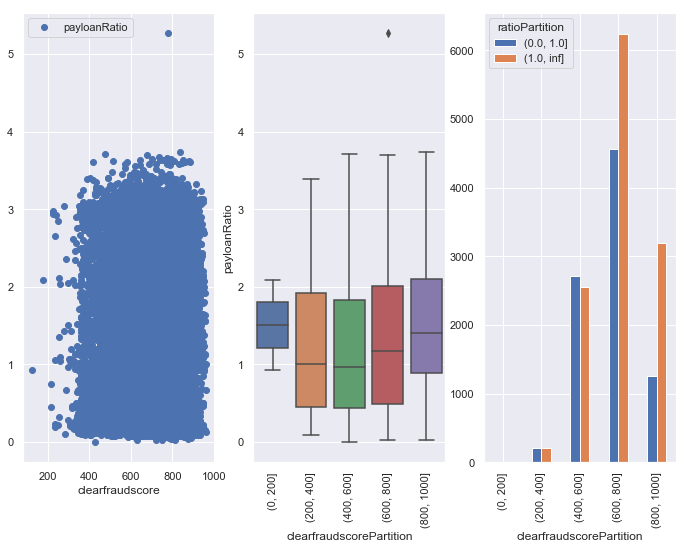

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

funded_loan.plot(x='clearfraudscore', y='payloanRatio', style='o', ax=ax1)
sns.boxplot(x=funded_loan['clearfraudscorePartition'], y=funded_loan['payloanRatio'], ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=90)
funded_loan.groupby(funded_loan['clearfraudscorePartition'])['ratioPartition'].value_counts().unstack().plot.bar(ax=ax3)
plt.show()

In [22]:
funded_loan['clearfraudscore'].corr(funded_loan['payloanRatio'], method='pearson')

0.11594194748314936

In [23]:
partition2 = pd.Series.to_frame(pd.cut(funded_loan['loanAmount'], [0, 1000, 2000, 3000, 4000, 5000]))
partition2.rename({'loanAmount': 'loanAmountPartition'}, axis=1, inplace=True)
funded_loan = pd.concat([funded_loan, partition2], axis=1)

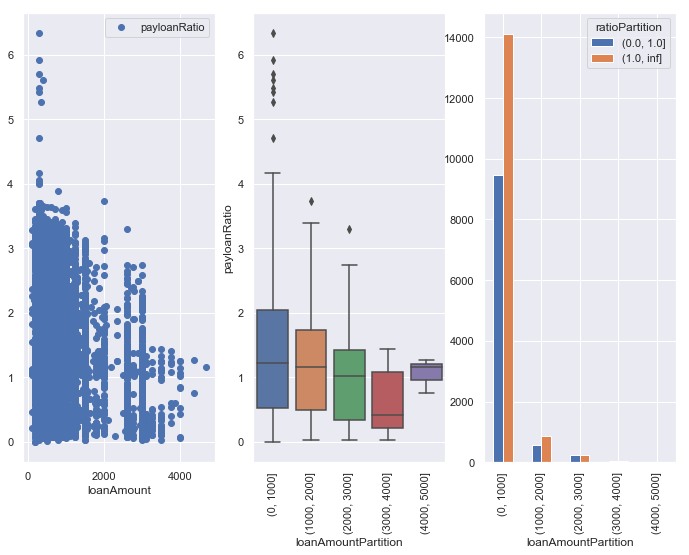

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

funded_loan.plot(x='loanAmount', y='payloanRatio', style='o', ax=ax1)
sns.boxplot(x=funded_loan['loanAmountPartition'], y=funded_loan['payloanRatio'], ax=ax2)
funded_loan.groupby(funded_loan['loanAmountPartition'])['ratioPartition'].value_counts().unstack().plot.bar(ax=ax3)
plt.setp(ax2.get_xticklabels(), rotation=90)

plt.show()

In [25]:
funded_loan['loanAmount'].corr(funded_loan['payloanRatio'], method='pearson')

-0.07952969953702321

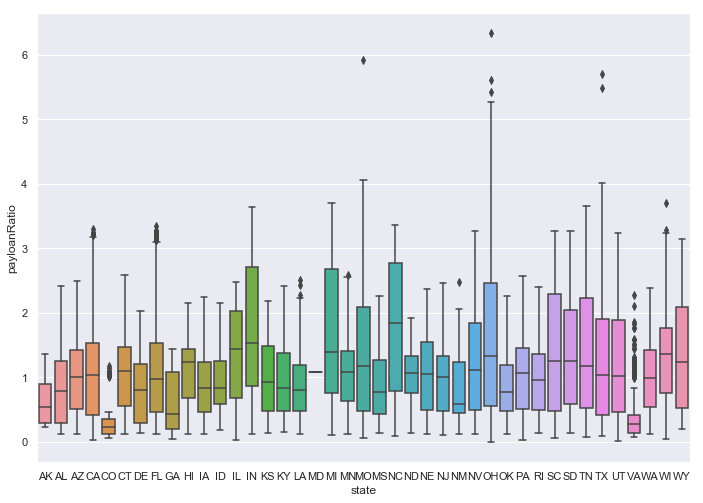

In [26]:
sns.boxplot(x=funded_loan.index.get_level_values('state'), y=funded_loan['payloanRatio'])
plt.show()

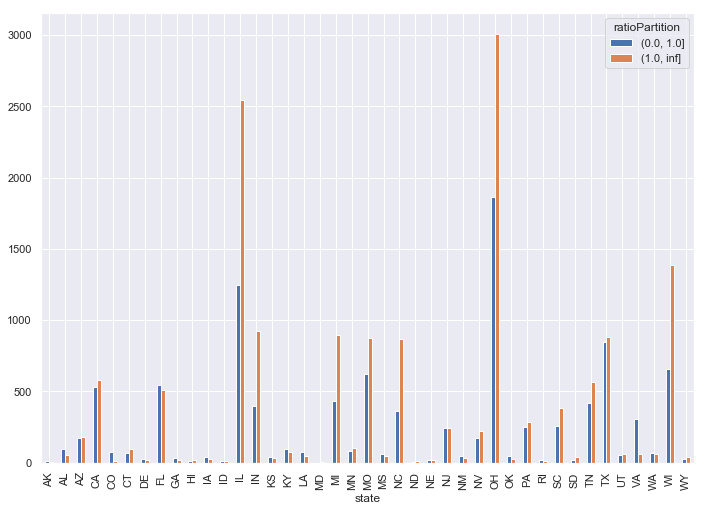

In [27]:
funded_loan.groupby(funded_loan.index.get_level_values('state'))['ratioPartition'].value_counts().unstack().plot.bar()



# Data for Model

In [28]:
funded_loan.reset_index(level=['state'], inplace=True)

In [29]:
input_columns_used_continuous = ['apr']
input_columns_used_categorical = ['state', 'payFrequency', 'nPaidOff', 'fpStatus', 'hasCF', 'clearfraudscorePartition', 'loanAmountPartition']
output_column = ['ratioPartition']
columns_used = input_columns_used_continuous + input_columns_used_categorical + output_column
data = funded_loan[columns_used]

In [30]:
missing_data(data)

,Total,Percentage
clearfraudscorePartition,5309,17.197927
ratioPartition,5267,17.061872
nPaidOff,21,0.068027
fpStatus,8,0.025915
loanAmountPartition,0,0.000000
hasCF,0,0.000000
payFrequency,0,0.000000
state,0,0.000000
apr,0,0.000000


Drop all rows with missing values for now. Check the results and might make changes later. Also the leadCost has not been taken into account. 'hasCF' only has value 0 after dropping NaN.

In [31]:
data.dropna(inplace=True)

/Users/limyiheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [32]:
missing_data(data)

,Total,Percentage
ratioPartition,0,0.0
loanAmountPartition,0,0.0
clearfraudscorePartition,0,0.0
hasCF,0,0.0
fpStatus,0,0.0
nPaidOff,0,0.0
payFrequency,0,0.0
state,0,0.0
apr,0,0.0


# Machine Learning Model

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [34]:
encoder = LabelEncoder()

In [35]:
data[input_columns_used_categorical + output_column] = data[input_columns_used_categorical + output_column].apply(encoder.fit_transform)

/Users/limyiheng/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [36]:
input_features = input_columns_used_continuous+input_columns_used_categorical
normalized_features =(data[input_features]-data[input_features].mean())/data[input_features].std()

In [37]:
data[input_features] = normalized_features

/Users/limyiheng/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [38]:
data.drop(columns=['hasCF'], inplace=True)

/Users/limyiheng/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 0:-1], data.iloc[:, -1], test_size=0.3, random_state=42)

In [40]:
clf = RandomForestClassifier()

In [41]:
clf.fit(X_train, y_train)

/Users/limyiheng/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
prediction = clf.predict(X_test)

In [43]:
confusion = pd.DataFrame(confusion_matrix(np.array(list(y_test)), prediction))
confusion.rename(columns={0: 'Actual Loss', 1: 'Actual Profit'}, index={0: 'Predicted Loss', 1: 'Predicted Profit'})

,Actual Loss,Actual Profit
Predicted Loss,1105,1529
Predicted Profit,836,2809


In [44]:
accuracy = accuracy_score(np.array(list(y_test)), prediction) * 100
accuracy

62.33476668259277

In [45]:
clf.feature_importances_

array([0.29300895, 0.28149718, 0.10304411, 0.09002628, 0.06336897,
       0.13549149, 0.03356301])